# Setup

In [5]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet scrnatools

In [43]:
import scrnatools as rna
import string
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import random
import os
import shutil

In [7]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
rna.configs.verbosity = "info"

# Import data

Downloads and loads the 3k pbmc example dataset provided with scanpy <br>
Otherwise import your own datasets folling the documentation at https://scanpy.readthedocs.io/en/latest/api.html#reading

In [8]:
adata = sc.datasets.pbmc3k()
# Store the raw counts data in a layer
adata.layers["raw_counts"] = adata.X.copy()
# FOR DEMO ONLY
# This sample data is human so gene names are capitalized, but immgen data for cell type similarity is from mouse so gene names only have first letter capitalized
# For real data analysis, do not do this, use a human reference for similarity scoring instead
adata.var_names = [string.capwords(i) for i in adata.var_names]
adata.var_names_make_unique()

100%|███████████████████████████████████████| 5.58M/5.58M [00:06<00:00, 910kB/s]


In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    layers: 'raw_counts'

# Doublet removal

Uses scrublet (https://github.com/swolock/scrublet) to filter out potential doublets in each batch

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 41.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.4%
Elapsed time: 5.0 seconds
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 48.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.7%


2023-04-05 11:11:25 - scrublet - INFO: 2.259% of cells classified as doublets (61 cells)


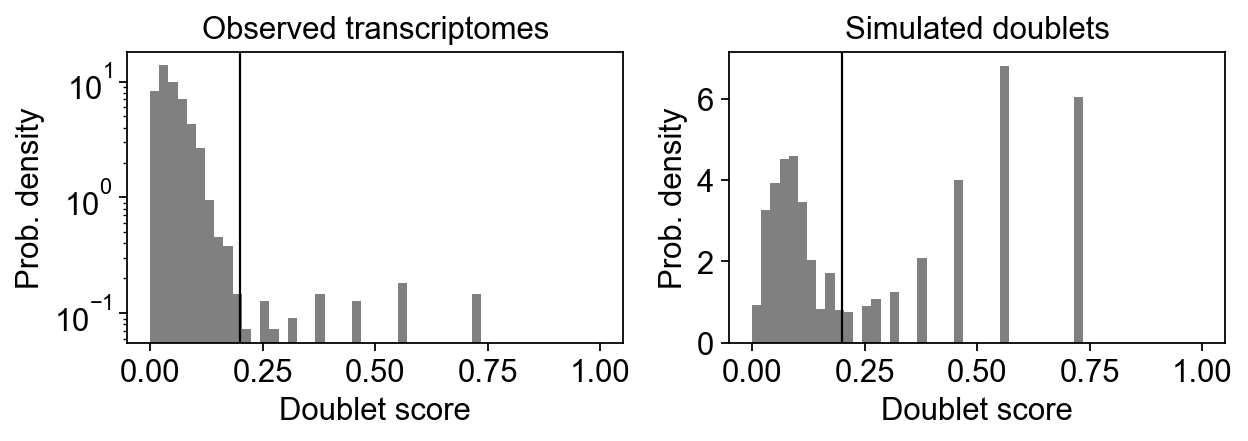

In [10]:
adata = rna.qc.scrublet(
    adata,
    doublet_threshold = 0.2, # Score threshold to use to call doublets
    batch_key = None, # Use batch information from a column in 'adata.obs' to run scrublet on each batch independently
    raw_counts_layer = "raw_counts" # use the raw counts data
)

In [11]:
adata

AnnData object with n_obs × n_vars = 2639 × 32738
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet'
    var: 'gene_ids'
    layers: 'raw_counts'

# Preprocessing

## Get QC metrics using scanpy

In [12]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## Filter cells based on QC metrics

2023-04-05 11:13:19 - qc_plotting - INFO: Saving figure to analysis/qc_plots.png


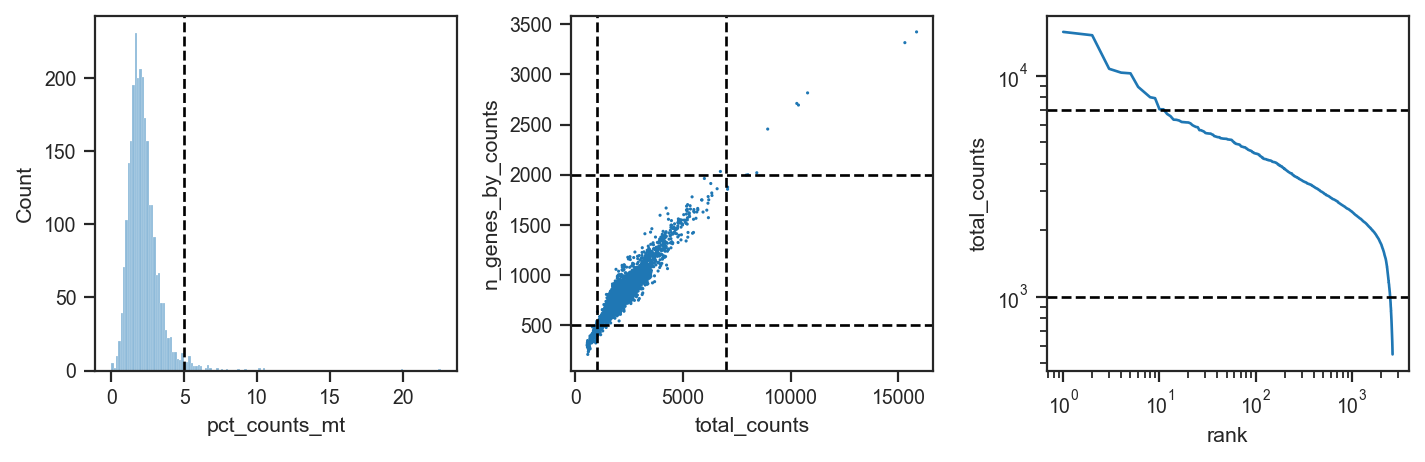

In [13]:
counts_thresholds=(1000, 7000) # The lower and upper total_counts thresholds
genes_thresholds=(500, 2000) # The lower and upper n_genes_by_counts thresholds
mt_threshold=5 # The pct_counts_mt threshold

rna.pl.qc_plotting(
    adata,
    counts_thresholds=counts_thresholds,
    genes_thresholds=genes_thresholds,
    mt_threshold=mt_threshold,
    show_thresholds=True, # Whether to show the thresholds on the figure
    batch_key=None, # Batch keys in adata.obs to plot seperately
    show_legend=False, # Whether to show the batch key legend
    figsize=(9, 3),
    dpi=300,
    save_path="analysis/qc_plots.png",
)

2023-04-05 11:14:09 - filter_cells - INFO: Number of cells before QC filtering: 2639
2023-04-05 11:14:09 - filter_cells - INFO: Number of cells after QC filtering: 2384
2023-04-05 11:14:09 - qc_plotting - INFO: Saving figure to analysis/filtered_qc_plots.png


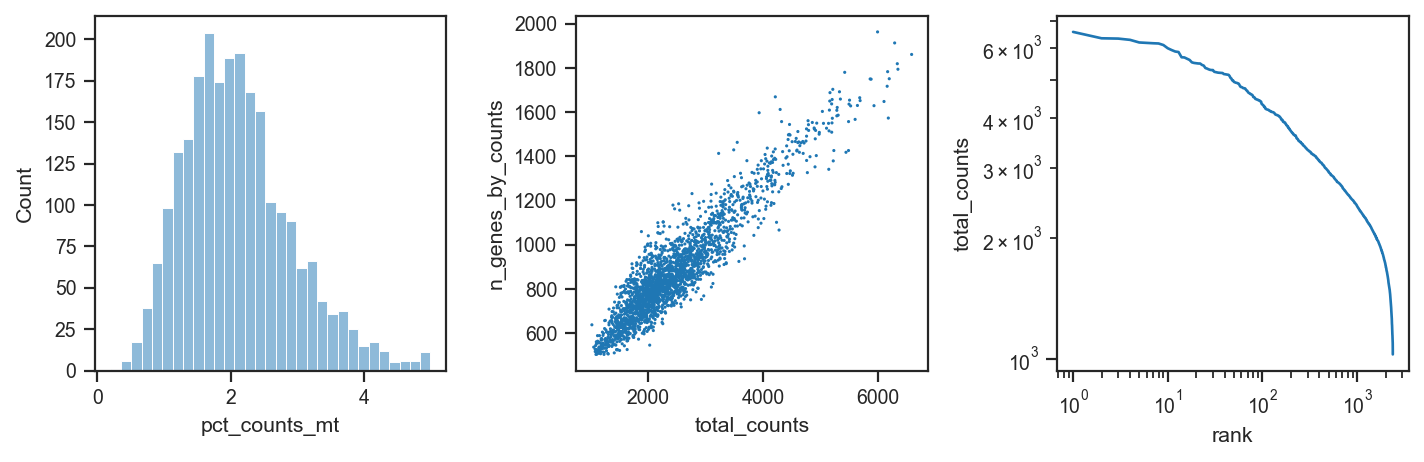

In [14]:
filteredAdata = rna.qc.filter_cells(
    adata,
    counts_thresholds=counts_thresholds, # The lower and upper total_counts thresholds
    genes_thresholds=genes_thresholds, # The lower and upper n_genes_by_counts thresholds
    mt_threshold=mt_threshold, # The pct_counts_mt threshold
)
rna.pl.qc_plotting(
    filteredAdata,
    show_thresholds=False,
    save_path="analysis/filtered_qc_plots.png",
)

In [15]:
# Once you're happy with qc cell filtering, overwrite adata with the filtered adata
adata = filteredAdata
del filteredAdata

## Log transform data with scanpy

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

## Subset genes

This step is recommended, but some analysis can be done using all genes instead of filtering genes by absolute expression or variability of expression

In [17]:
# Subset on highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200, # Number of HVGs to keep
    subset=True, # Subset the adata in place
    layer="raw_counts", # Use the raw counts data for calculations
    flavor="seurat_v3", # HVG algorithm to use
    batch_key=None, # Column in adata.obs that annotates batches of data
)

# Or subset on genes above minimum average expression threshold
# adata = adata[:, adata.var.mean_counts > 0.01].copy()

ImportError: Please install skmisc package via `pip install --user scikit-misc

In [18]:
adata

AnnData object with n_obs × n_vars = 2384 × 16576
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'raw_counts'

## Normalize data with scanpy

This step is optional for use when downstream analysis is done within scanpy, otherwise scVI normalization can be done on its own

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# Scanpy normalized expression is now stored in adata.X

## Normalize data with scVI

In [20]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    batch_key=None,
)
model = scvi.model.SCVI(adata)

In [21]:
# Train scVI model - run on google colab with a GPU session or a Windows machine with an Nvidia GPU
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██| 400/400 [30:32<00:00,  5.18s/it, loss=2.59e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [30:32<00:00,  4.58s/it, loss=2.59e+03, v_num=1]


In [22]:
if not os.path.isdir("data/scVI_models"):
    os.makedirs("data/scVI_models")
if os.path.isdir("data/scVI_models"):
    shutil.rmtree("data/scVI_models")
# save the scVI model and adata object before further processing because training is non-deterministic
model.save("data/scVI_models/pbmc_3k_1200_hvgs")
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

In [23]:
# To reload saved adata/scVI model later:
adata = sc.read("data/pbmc_3k_1200_hvgs.h5ad")
model = scvi.model.SCVI.load("data/scVI_models/pbmc_3k_1200_hvgs", adata=adata)

INFO     File data/scVI_models/pbmc_3k_1200_hvgs/model.pt already downloaded                                       


In [24]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [25]:
adata

AnnData object with n_obs × n_vars = 2384 × 16576
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p'
    obsm: 'X_scVI'
    layers: 'raw_counts', 'scVI_normalized'

# Dimensionality reduction

## UMAP

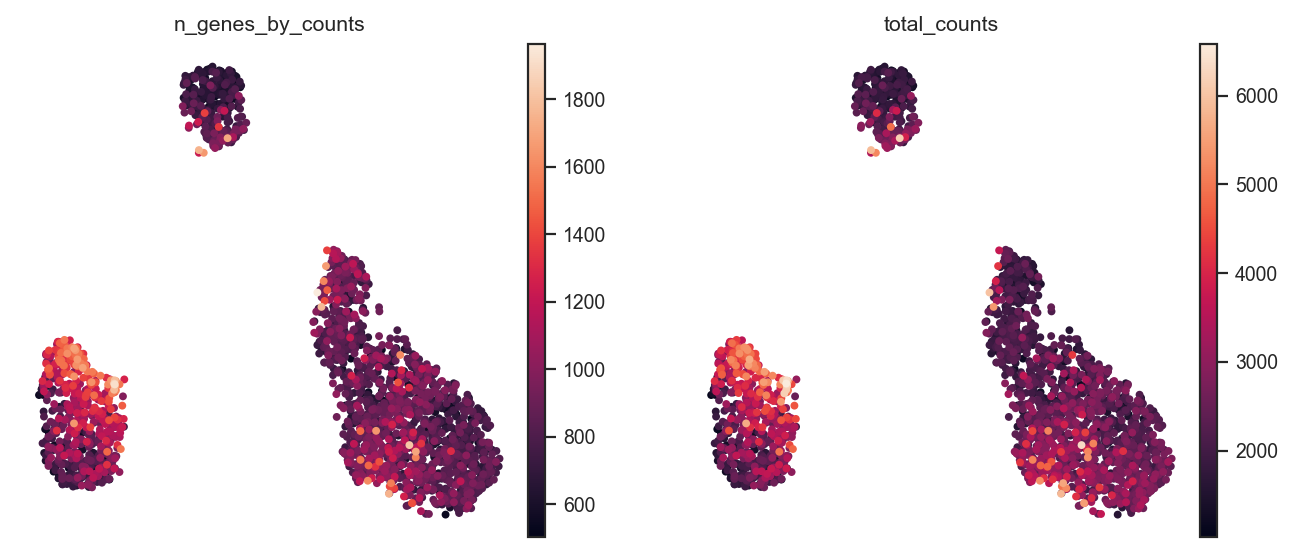

In [26]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

## TSNE

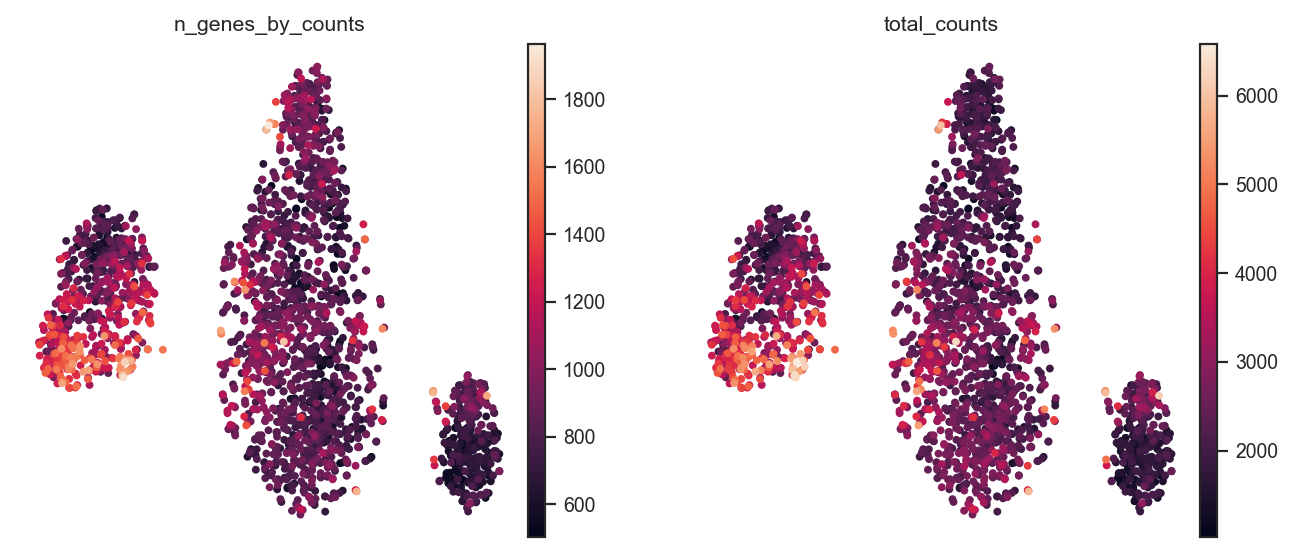

In [27]:
sc.tl.tsne(adata, use_rep="X_scVI")
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.tsne(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

# Clustering

/Users/nolanhorner/miniconda3/envs/scrnatools_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


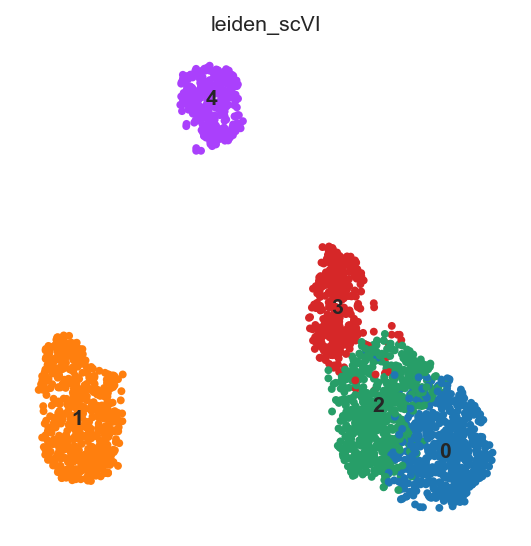

In [28]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
)

# Rename clusters to cell types

/Users/nolanhorner/miniconda3/envs/scrnatools_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


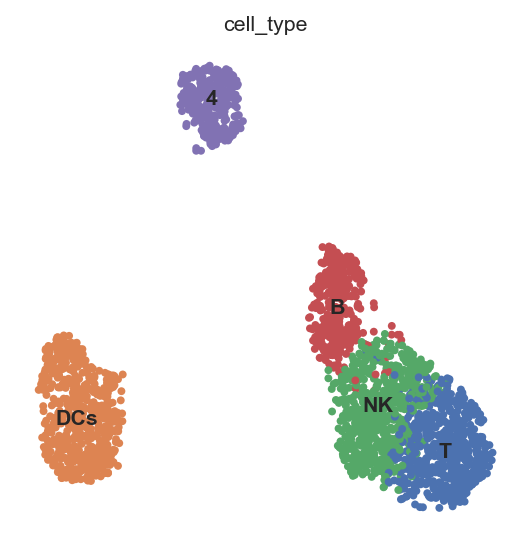

In [31]:
# Rename leiden clusters with corresponding cell types
cellTypes = {
    "0": "T",
    "1": "DCs",
    "2": "NK",
    "3": "B",
}
adata.obs["cell_type"] = adata.obs.leiden_scVI.replace(cellTypes)
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_loc="on data",
)

# Plot genes

## Heatmap

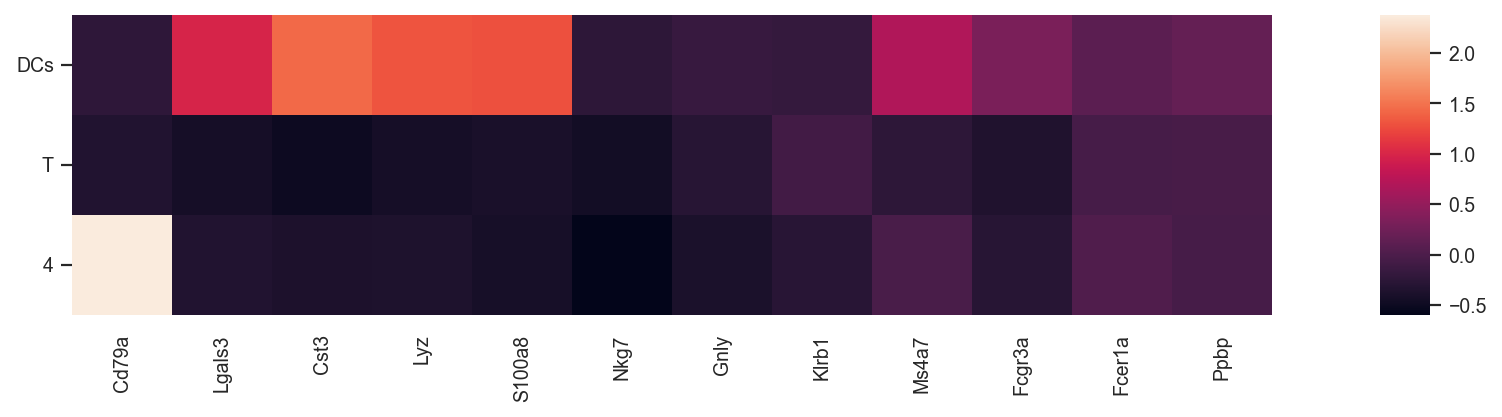

In [69]:
geneList = ["Cd79a", "Lyz", "Lgals3", "S100a8", "Gnly", "Nkg7", "Klrb1", "Fcgr3a", "Ms4a7", "Fcer1a", "Cst3", "Ppbp"]
rna.pl.gene_heatmap(
    adata,
    geneList,
    obs_key="cell_type", # categorical grouping to display
    obs_values=["DCs", "4", "T"], # values from obs key group to display
    layer="X", # can be a layer (i.e. 'raw_counts') or 'X'
    # cbar_args takes a list of integers to position color bar on heatmap. [x position, y position, width, height]. Default auto adjusts to right middle of heatmap.
    reverse_axis=False, # boolean to reverse x and y axes. Default False
    cell_size=50, # integer specifying the size of each cell in the heatmap
    dpi=80, # resolution of figure to show
    # save_path specifies path to save figure
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

## Violinplot

In [70]:
# Create fake condition/control groups
random.seed(0)
adata.obs["genotype"] = [bool(random.getrandbits(1)) for i in range(0,len(adata))]
adata.obs.genotype = adata.obs.genotype.replace({True: "KO", False: "WT"})

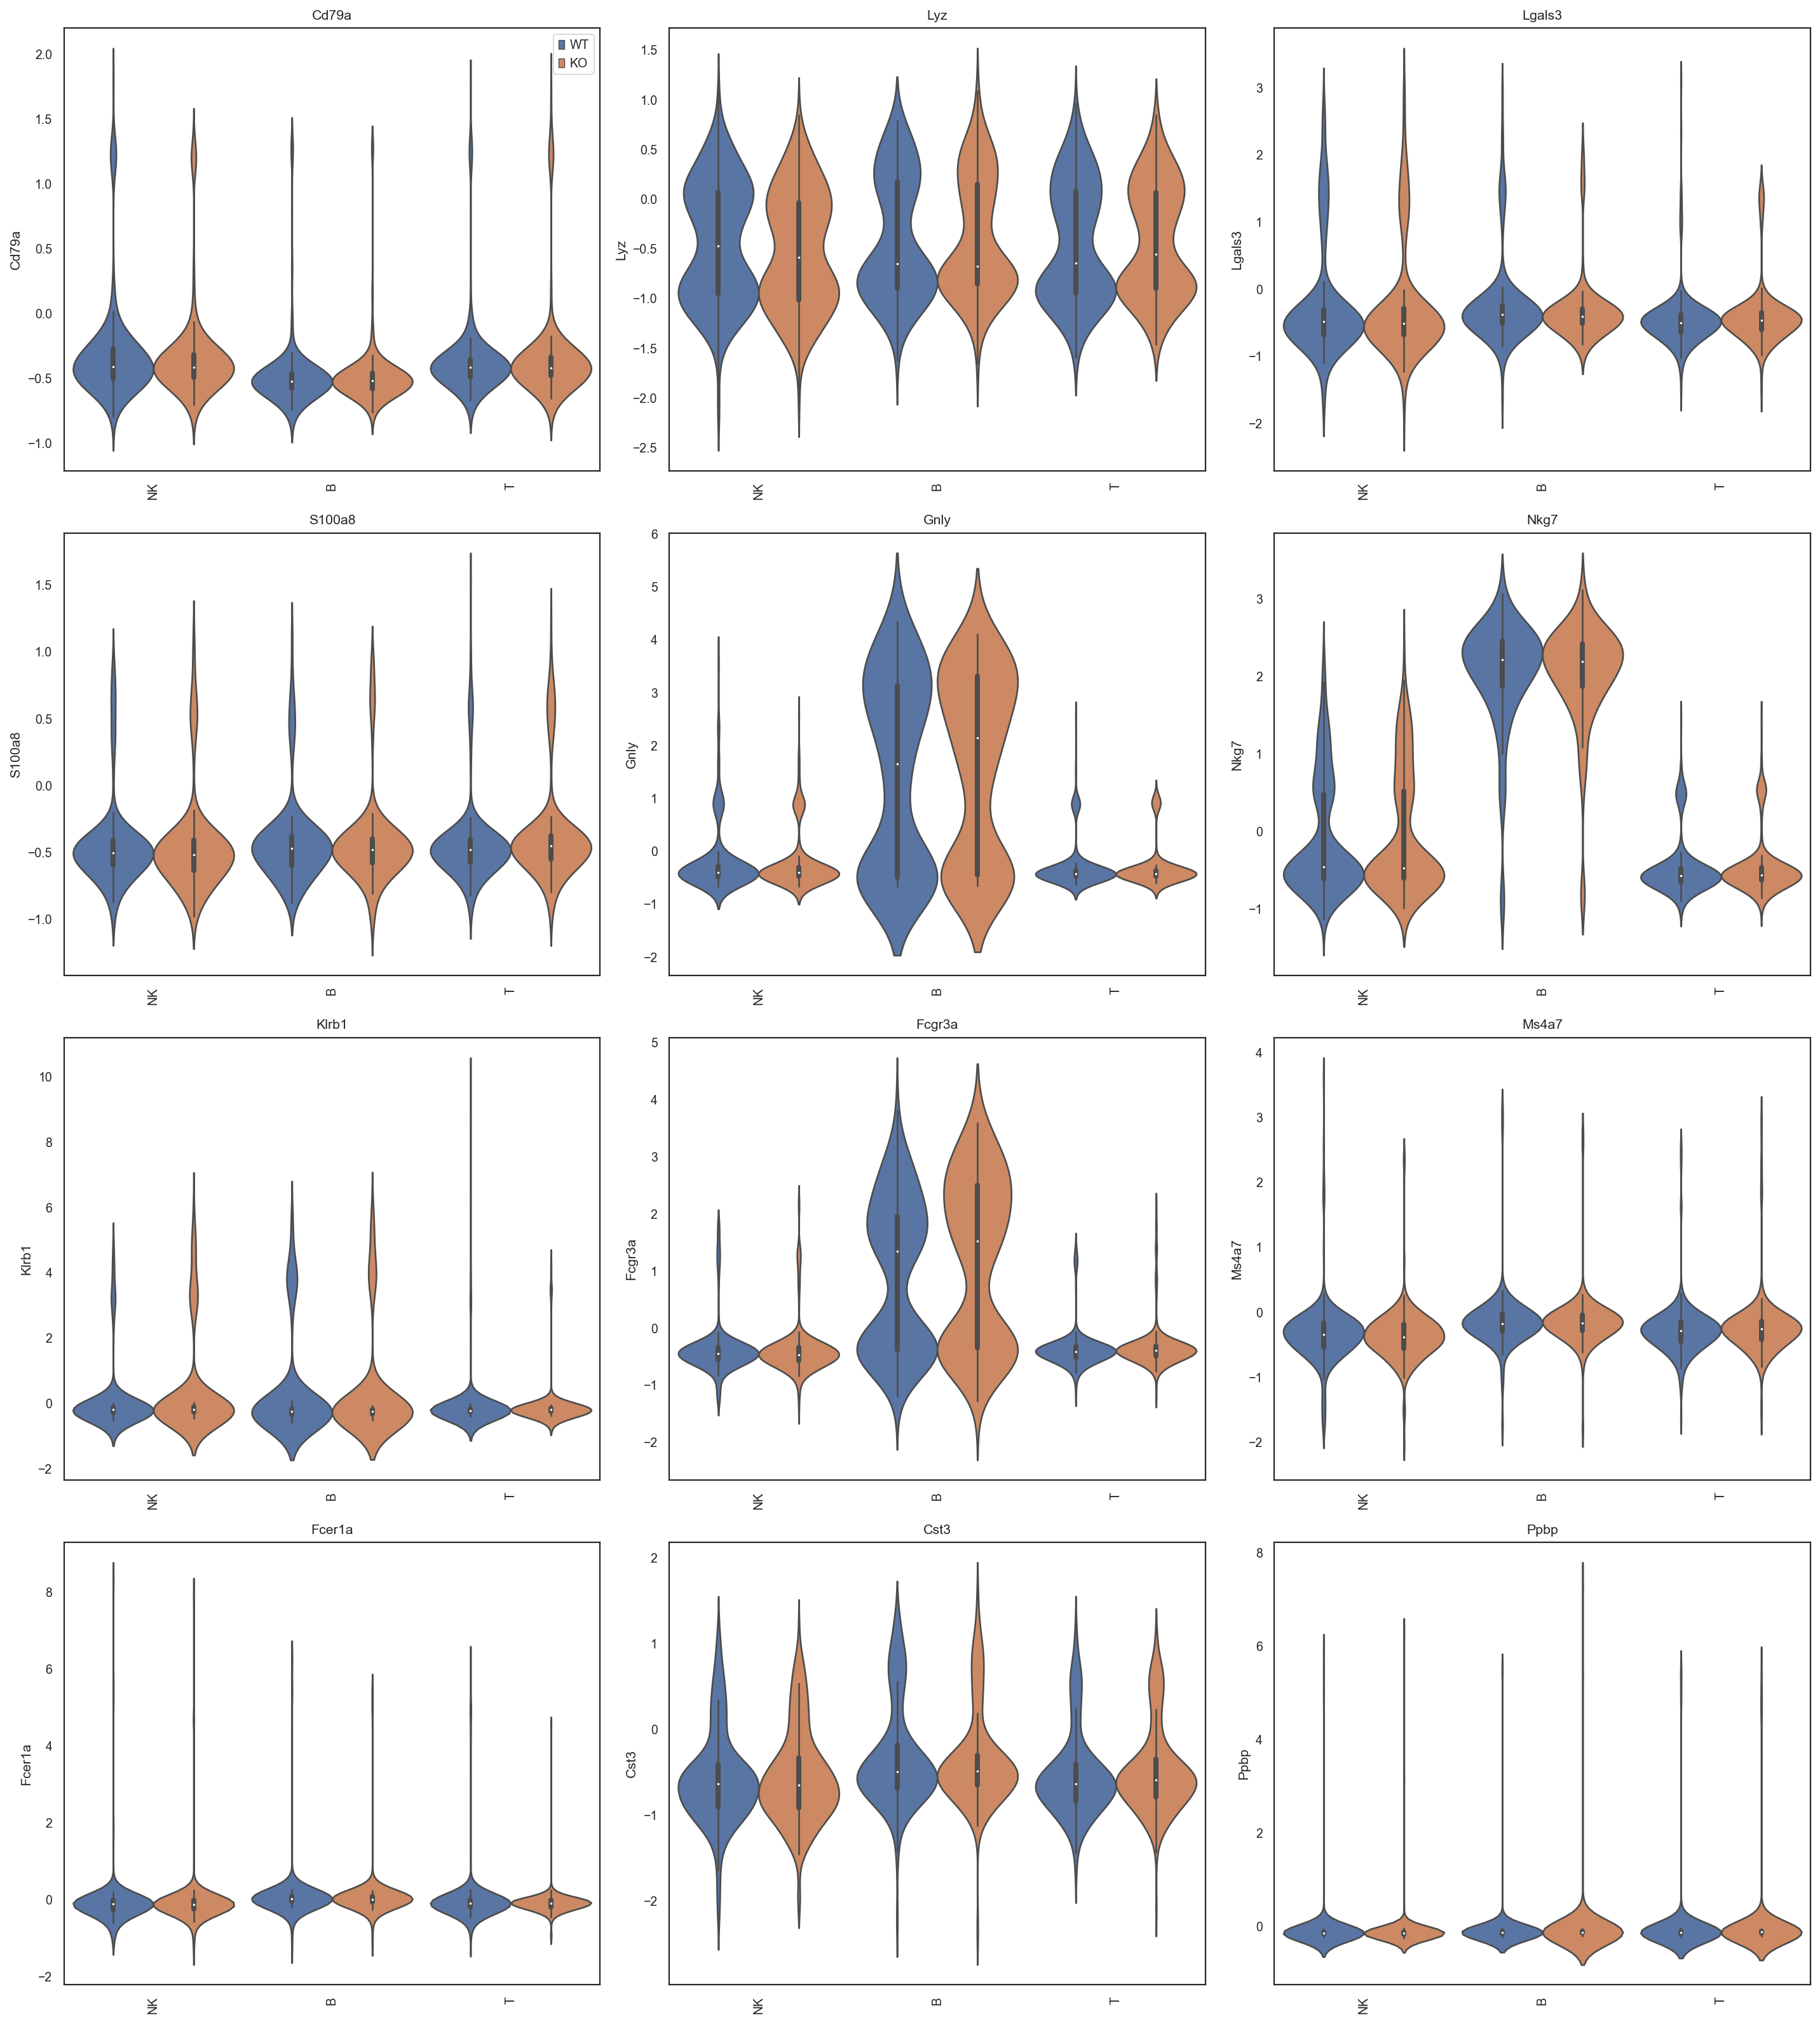

In [71]:
rna.pl.gene_violinplot(
    adata,
    geneList,
    x_key="cell_type", # categorical grouping to display on the x axis
    x_values=["NK", "B", "T"], # values from x key group to display. Defaults to ["All"] values
    layer="X", # can be a layer (i.e. 'raw_counts') or 'X'
    hue_key="genotype", # categorical grouping to color the grouped violin plots by
    hue_values=["WT", "KO"], # values from hue_key to display. Values will appear in legend. Defaults to ["All"] values
    ncols=3, # number of columns for plots to display
    nrows=4, # number of rows for plots to display. ncols * nrows must be > or = total number of genes in geneList to display
    dpi=80, # resolution of figure
    # save_path specifies path to save figure
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

## UMAP/TSNE

In [29]:
geneList = ["Cd79a", "Lyz", "Lgals3", "S100a8", "Gnly", "Nkg7", "Klrb1", "Fcgr3a", "Ms4a7", "Fcer1a", "Cst3", "Ppbp"]
sc.settings.figdir = "analysis"
# use rna.pl.gene_tsne() to use tsne latent rep instead
rna.pl.gene_umap(
    adata,
    geneList,
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    use_rep = "X_umap", # the embedding coordinates in 'adata.obsm' to use
    save="_marker_genes_scvi_expression.png"
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

AttributeError: module 'scrnatools.plotting' has no attribute 'gene_umap'

## Gene density plot

2023-04-05 11:54:09 - gene_density_plot - INFO: Saving figure to analysis/umap_marker_genes_density.png


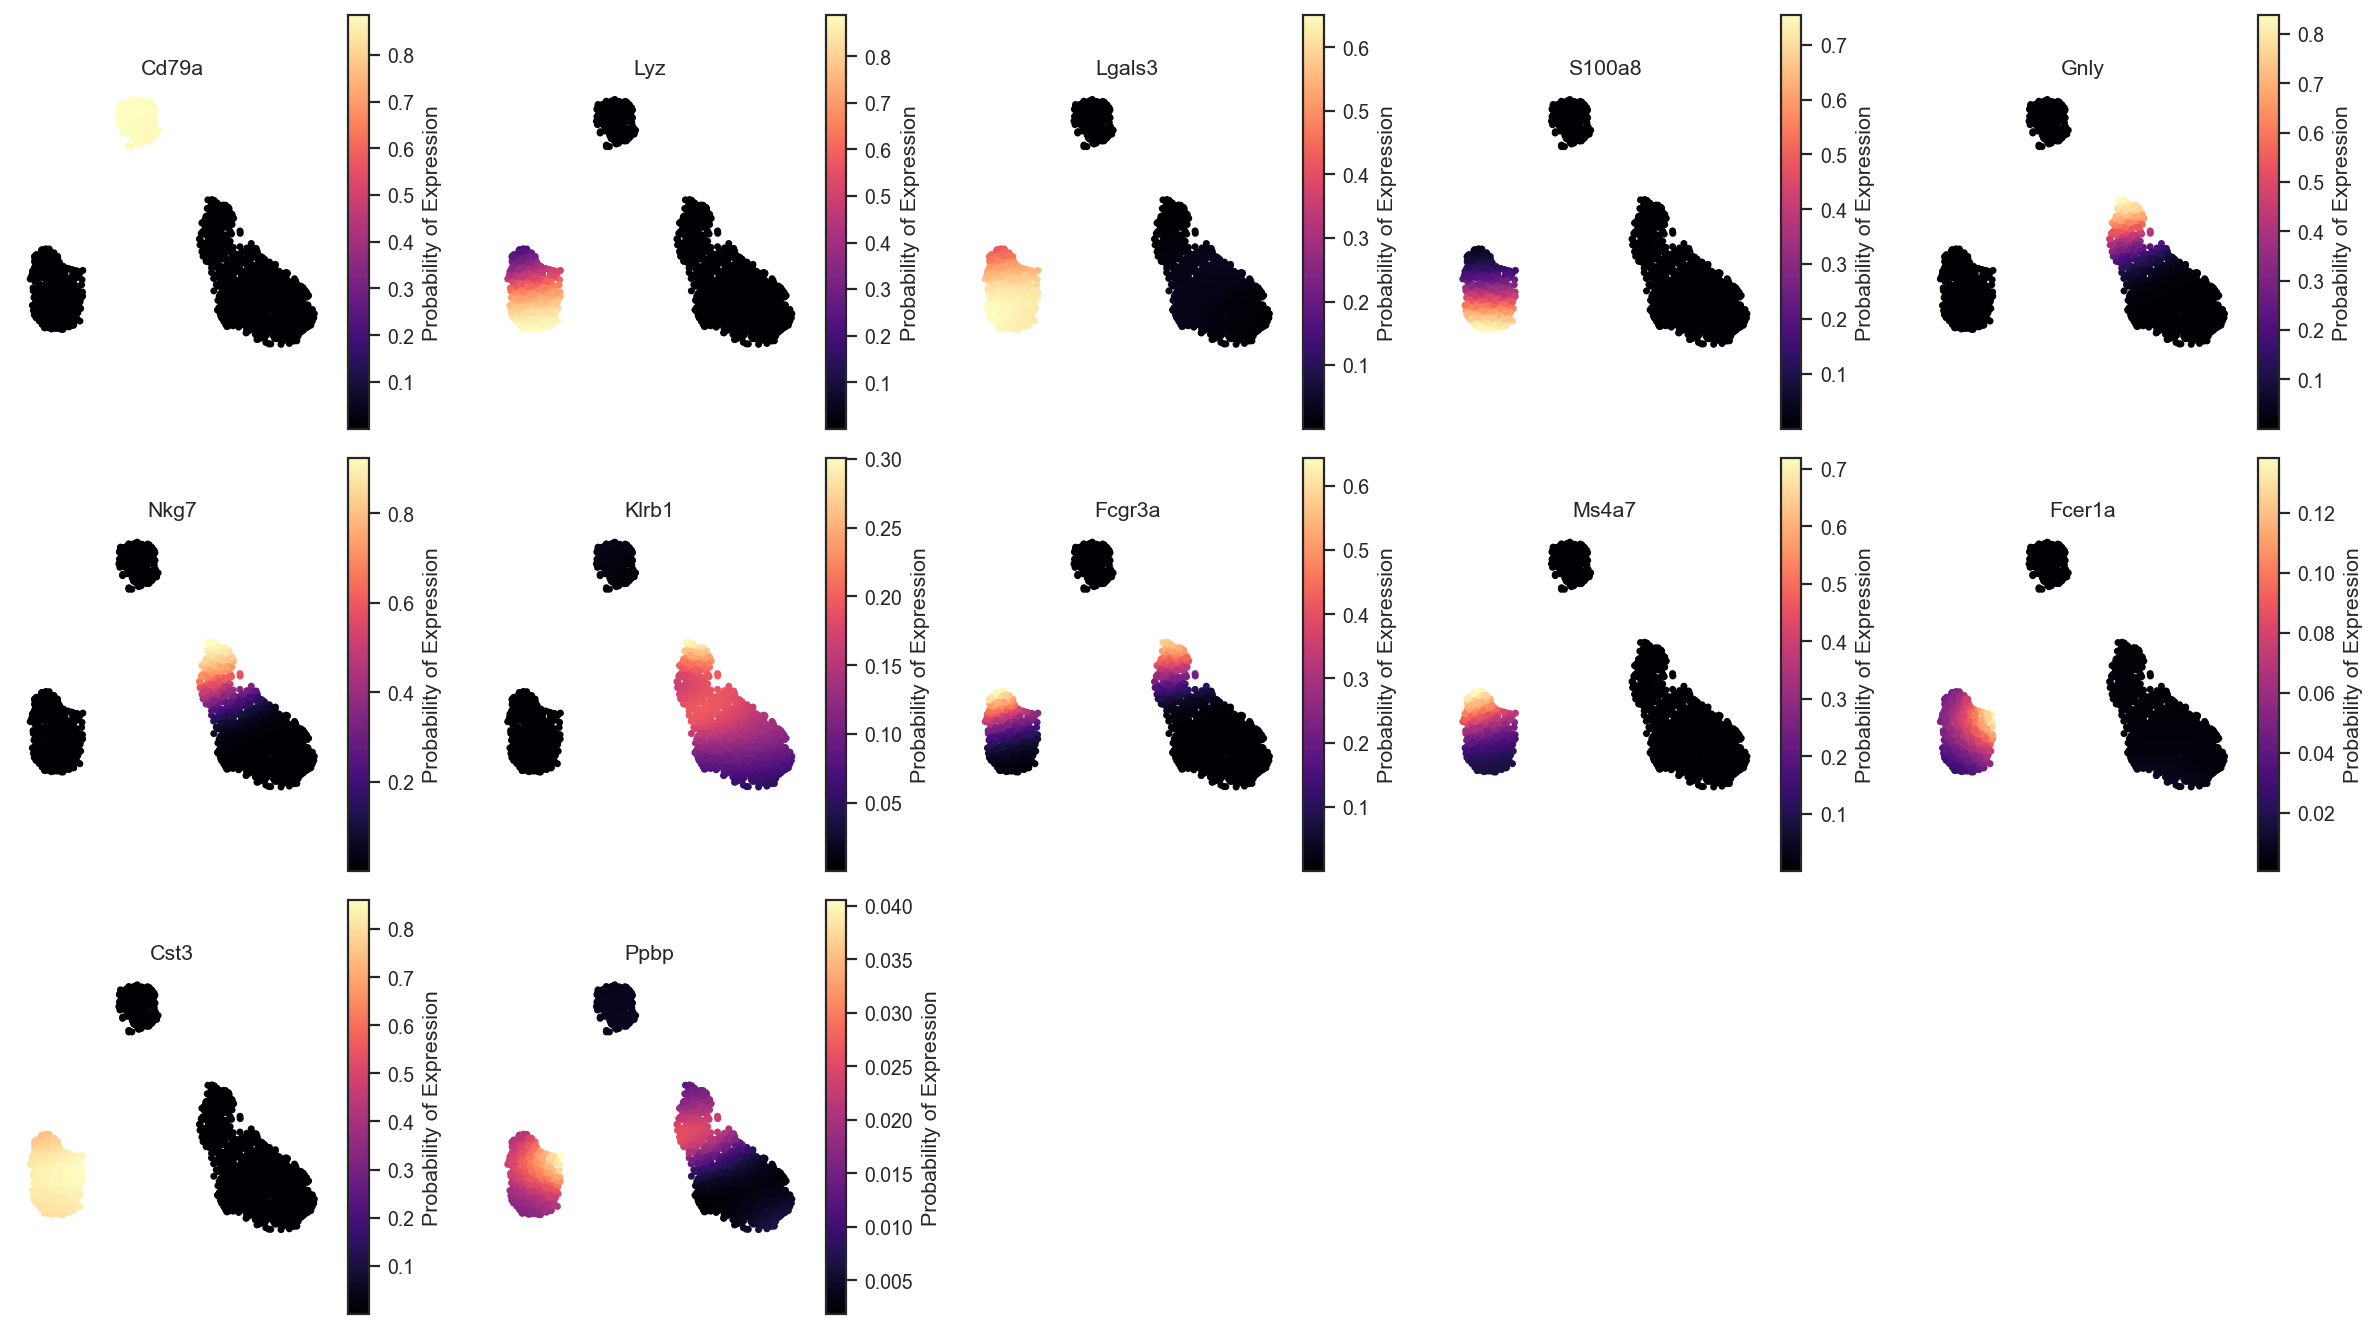

In [30]:
rna.pl.gene_density_plot(
        adata,
        geneList,
        data_loc="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
        latent_rep="X_umap", # The latent rep to calculate density over
        cmap="magma", # The colormap to use (see matplotlib.pyplot documentation for options)
        s=10, # Size of each data point
        ncols=5, # Number of columns in the figure
        figsize=(3, 3), # Size of each panel
        title=None,
        save_path="analysis/umap_marker_genes_density.png",
        dpi=300, # Resolution of saved figure
)

# Cluster DE marker genes

In [32]:
deGenes = rna.tl.cluster_de(
    adata,
    model, # Trained scVI model for the data
    cluster_key="cell_type", # cell type labels to calculate DE genes between
    lfc_mean_threshold=0, # Minimum LFC to consider a DE gene (default to only look at >0, i.e. genes with higher expression in a given cluster than everywhere else)
    bayes_factor_threshold=3, # Minimum bayes factor to consider a DE gene (see scVI documentation for explanation)
    non_zeroes_proportion_threshold=0.1, # Minimum proportion of cells with non-zero expression to consider a DE gene (removes stochastic noise/contamination)
    subset=True, # Whether to subset the DE gene list based on thresholds or return all genes in data
    save_path="analysis/DE", # Folder to save DE gene dataframes to
)

DE...: 100%|██████████████████████████████████████| 5/5 [00:41<00:00,  8.20s/it]


In [33]:
deGenes["B"].head(10)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Nkg7,0.9974,0.0026,5.949637,0.006942,0.000246,0.0,0.25,5.765828,5.852772,2.102172,...,17.974762,0.463473,0.974763,0.202225,92.618271,1.899516,True,B vs Rest,B,Rest
Cst7,0.9958,0.0042,5.468460,0.001539,0.000093,0.0,0.25,4.703945,4.768462,1.763399,...,3.791793,0.137397,0.921136,0.090953,20.064617,0.576060,True,B vs Rest,B,Rest
Gnly,0.9956,0.0044,5.421739,0.003945,0.000106,0.0,0.25,5.506459,5.705627,2.313476,...,11.627761,0.200291,0.618297,0.119013,59.579651,0.791585,True,B vs Rest,B,Rest
Fgfbp2,0.9956,0.0044,5.421739,0.001455,0.000043,0.0,0.25,5.280376,5.400399,2.020416,...,2.955831,0.040155,0.646688,0.033866,15.798367,0.158227,True,B vs Rest,B,Rest
Gzmh,0.9946,0.0054,5.215940,0.001259,0.000042,0.0,0.25,6.055876,6.221277,2.270264,...,2.649839,0.031930,0.646688,0.024673,13.493500,0.125960,True,B vs Rest,B,Rest
Prf1,0.9930,0.0070,4.954819,0.001486,0.000059,0.0,0.25,4.962067,5.022829,2.239826,...,2.996840,0.095307,0.731861,0.075472,15.415143,0.391459,True,B vs Rest,B,Rest
Cd160,0.9926,0.0074,4.898846,0.000313,0.000014,0.0,0.25,6.867226,6.598050,4.111507,...,0.283912,0.011611,0.164038,0.009192,1.555819,0.053660,True,B vs Rest,B,Rest
Gzmb,0.9908,0.0092,4.679308,0.002369,0.000063,0.0,0.25,5.357106,5.589643,2.453089,...,5.350154,0.076923,0.690852,0.040639,27.425526,0.265016,True,B vs Rest,B,Rest
Gzma,0.9900,0.0100,4.595119,0.001690,0.000112,0.0,0.25,5.120907,5.280488,2.084997,...,3.463719,0.189163,0.867508,0.101597,17.608351,0.838451,True,B vs Rest,B,Rest
Ctsw,0.9898,0.0102,4.575114,0.001606,0.000157,0.0,0.25,4.006942,3.962608,1.839891,...,3.690846,0.325592,0.914826,0.214804,19.165791,1.348694,True,B vs Rest,B,Rest


# Cell type similarity

## Get immgen cell type signatures

In [29]:
# Download and load the immgen cell type signature data to a folder at save_path
immgen = rna.tl.get_immgen_similarity_signatures(save_path="data") 
immgen

,SC_LT34F_BM,SC_LTSL_BM,SC_STSL_BM,SC_LTSL_FL,SC_STSL_FL,SC_MPP34F_BM,SC_ST34F_BM,SC_CMP_BM,SC_MEP_BM,SC_GMP_BM,...,Ep_MEChi_Th,Fi_MTS15+_Th,Fi_Sk,FRC_MLN,FRC_SLN,LEC_MLN,LEC_SLN,BEC_MLN,BEC_SLN,St_31-38-44-_SLN
gene_name,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,6.797117,6.360333,6.662006,6.427335,6.437454,6.679156,6.790981,6.943933,7.635508,7.117373,...,6.476976,6.609829,6.502716,6.731251,6.780717,6.816932,7.149442,6.942866,6.996807,6.529115
0610009L18Rik,7.316544,8.168883,7.861428,7.800822,7.507517,7.541081,7.455853,7.620293,7.114336,7.677924,...,7.996490,7.452834,7.537444,7.763949,7.545011,7.574276,7.177180,7.643272,7.463900,7.600032
0610010F05Rik,7.400632,7.056768,7.160870,7.381136,7.572367,7.270314,7.473560,7.626782,7.475628,6.164643,...,7.275631,6.908525,6.612712,5.439932,6.098217,6.716511,7.119968,6.492121,6.728206,6.356234
0610010K14Rik,9.246308,9.295594,8.917933,9.367240,9.247446,9.598990,9.599037,9.286498,9.292842,10.031798,...,8.417190,8.377814,9.693119,8.777117,8.631075,9.212467,9.399297,9.395945,9.408379,8.609123
0610038B21Rik,5.861660,6.171731,5.818086,6.296947,6.031117,6.096877,5.932255,6.636587,6.368213,6.342167,...,6.041710,5.763672,6.043463,6.192078,5.952597,5.838795,5.687346,6.040654,5.863289,6.197374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx,9.272275,10.091382,10.290411,9.686166,9.693199,9.263065,9.275447,9.290837,7.203798,9.167604,...,7.627300,8.744558,9.711825,9.024311,8.776755,9.386212,9.366995,9.160313,9.040734,9.292802
Zzef1,8.120165,8.430231,8.487346,8.168742,8.455237,7.849267,8.083128,8.474797,8.285157,7.571358,...,7.780487,8.307825,7.919775,7.882258,8.075704,8.389248,8.321919,8.261564,8.307784,7.852217
Zzz3,9.536164,9.641560,9.469255,9.798141,9.703494,9.309358,9.564820,9.540835,9.438682,7.894254,...,8.883996,9.326355,8.868233,8.466615,8.921892,8.794250,9.027696,8.824545,8.883593,8.514935


## Cosine similarity to immgen cell types

In [30]:
# Cell type similarity scores for each cell are added as columns to adata.obs
adata=rna.tl.cell_type_similarity(
    adata,
    signatures=immgen, # The gene x cell type DataFrame containing cell type signatures for scoring
)
# Each column is named (cell_type)_cosine_similarity_cell_z_score

2022-07-18 22:05:58 - cell_type_similarity - INFO: Scaling cosine similarity scores to z-scores by cell
INFO:cell_type_similarity:Scaling cosine similarity scores to z-scores by cell


In [31]:
# List all similarity scores
[i for i in adata.obs.columns if "cosine_similarity" in i]

['SC_LT34F_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_BM_cosine_similarity_cell_z_score',
 'SC_STSL_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_FL_cosine_similarity_cell_z_score',
 'SC_STSL_FL_cosine_similarity_cell_z_score',
 'SC_MPP34F_BM_cosine_similarity_cell_z_score',
 'SC_ST34F_BM_cosine_similarity_cell_z_score',
 'SC_CMP_BM_cosine_similarity_cell_z_score',
 'SC_MEP_BM_cosine_similarity_cell_z_score',
 'SC_GMP_BM_cosine_similarity_cell_z_score',
 'SC_CDP_BM_cosine_similarity_cell_z_score',
 'SC_MDP_BM_cosine_similarity_cell_z_score',
 'MLP_BM_cosine_similarity_cell_z_score',
 'MLP_FL_cosine_similarity_cell_z_score',
 'proB_CLP_BM_cosine_similarity_cell_z_score',
 'proB_FrA_BM_cosine_similarity_cell_z_score',
 'proB_FrBC_BM_cosine_similarity_cell_z_score',
 'preB_FrC_BM_cosine_similarity_cell_z_score',
 'preB_FrD_BM_cosine_similarity_cell_z_score',
 'B_FrE_BM_cosine_similarity_cell_z_score',
 'proB_CLP_FL_cosine_similarity_cell_z_score',
 'proB_FrA_FL_cosine_similarity_cell_z

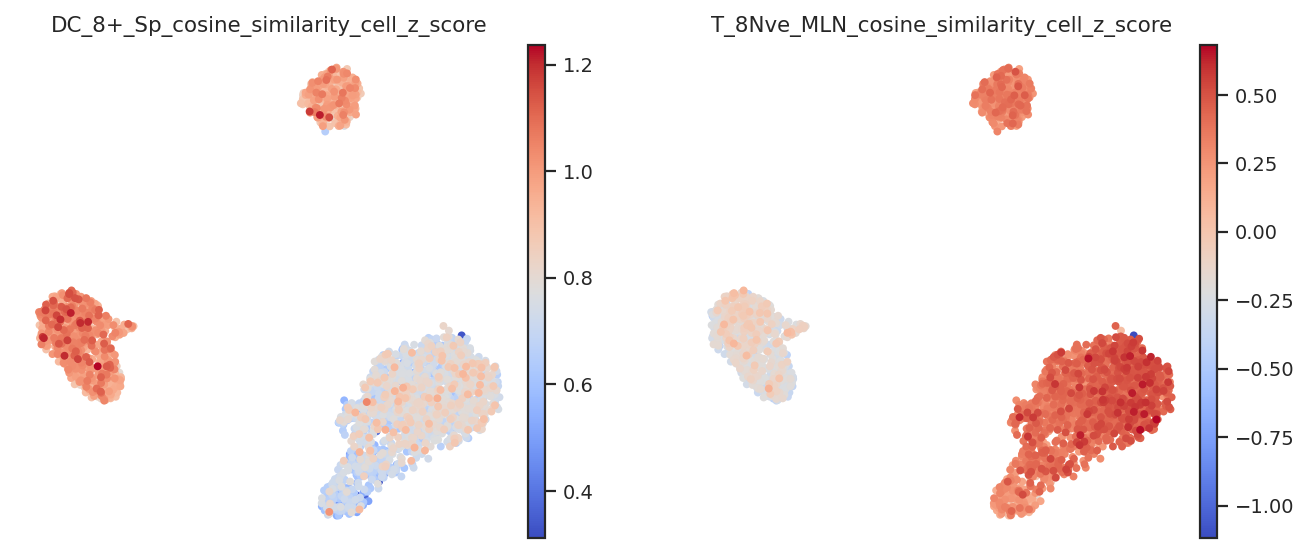

In [32]:
# Plot selected similarity scores
sc.pl.umap(
    adata,
    color=["DC_8+_Sp_cosine_similarity_cell_z_score", "T_8Nve_MLN_cosine_similarity_cell_z_score"],
    cmap="coolwarm",
)

## Create a new signature file for similarity scoring using this data

In [62]:
# Pseudobulk a single cell datset by cell type to create new cell type signatures for scoring
rna.tl.create_cell_type_signature(
    adata,
    save_path="analysis/pbmc3k_cell_type_signature.csv", # The path to save the signature to
    cell_type_labels="cell_type", # The column in adata.obs that contains cell type annotations
    data_loc="raw", # The location of expression data to use (must be cell size normalized and log-transformed counts).
                    # By default this uses the raw attribute, which in this pipeline contains ALL genes in the dataset,
                    # But the subset of genes within adata.X or a layer could be used as long as the expression data is 
                    # log-transformed counts.
)

2023-04-05 13:24:16 - create_cell_type_signature - INFO: Saving signature DataFrame to analysis/pbmc3k_cell_type_signature.csv


,NK,4,DCs,B,T
Al627309.1,0.002294,0.000000,0.015946,0.005933,0.002793
Ap006222.2,0.000000,0.000000,0.003088,0.004548,0.002692
Rp11-206l10.2,0.000000,0.010359,0.001561,0.000000,0.003064
Rp11-206l10.9,0.000000,0.000000,0.006073,0.000000,0.000000
Fam87b,0.000000,0.000000,0.004273,0.000000,0.000000
...,...,...,...,...,...
Ac011841.1,0.003099,0.006804,0.000000,0.000000,0.000000
Al354822.1,0.000000,0.007257,0.005619,0.000000,0.005144
Kir2dl2,0.000000,0.000000,0.000000,0.005709,0.000000
Pnrc2-1,0.098037,0.059466,0.046496,0.075004,0.067929


# Differential density

In [63]:
# Create fake condition/control groups
random.seed(0)
adata.obs["genotype"] = [bool(random.getrandbits(1)) for i in range(0,len(adata))]
adata.obs.genotype = adata.obs.genotype.replace({True: "KO", False: "WT"})

In [64]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype", # The column in adata.obs containing condition/control labels
    groups=["KO", "WT"], # The condition/control labels in adata.obs[group_by] to use
    latent_rep="X_umap", # The latent representation to calculate density over
    key_added="KO/WT_log_density_ratio", # The column to add to adta.obs with the differential density ratio
)

2023-04-05 13:24:20 - log_density_ratio - INFO: Calculating log density ratio of WT/KO


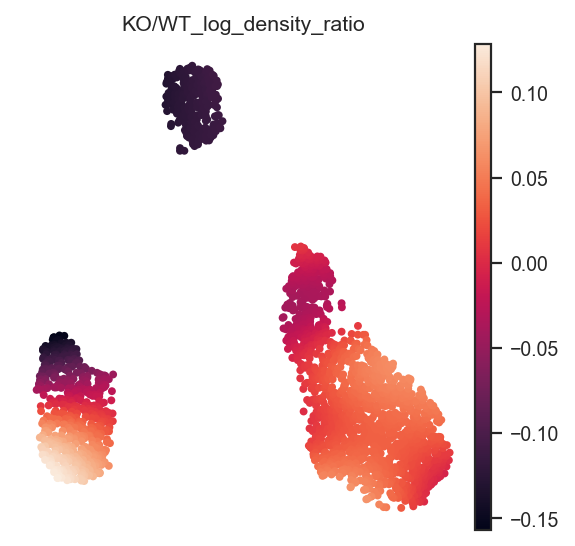

In [65]:
sc.pl.umap(
    adata,
    color="KO/WT_log_density_ratio",
)
# As expected there is not significant enrichment of either randomly assigned genotype in a particular region on the UMAP (note the colorbar scale)

# Save anndata

In [66]:
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

# Other tools

## Get expression matrix

In [67]:
# Returns a cell x gene DataFrame with expression data from 'adata.X' 'adata.raw' or a layer in 'adata.layers'
data = rna.tl.get_expression_matrix(
    adata,
    "scVI_normalized", # Can be 'X', 'raw', or a layer in 'adata.layers'
)
data.index=adata.obs.index
data.columns=adata.var_names
data

,Al627309.1,Ap006222.2,Rp11-206l10.2,Rp11-206l10.9,Fam87b,Linc00115,Fam41c,Samd11,Noc2l,Klhl17,...,Mt-nd6,Mt-cyb,Ac145212.1,Ac011043.1,Al592183.1,Ac011841.1,Al354822.1,Kir2dl2,Pnrc2-1,Srsf10-1
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.002007,6.602130e-05,2.970915e-04,1.762177e-03,1.737471e-03,0.059558,0.000205,0.001237,0.629151,0.001923,...,0.763346,30.817766,0.085153,0.000434,0.786770,0.000248,0.001167,0.000125,0.334369,0.237159
AAACATTGAGCTAC-1,0.000036,1.376380e-04,2.607559e-05,4.378753e-07,7.717100e-08,0.006072,0.017631,0.000104,0.288216,0.021801,...,0.089696,18.930428,0.005772,0.000004,2.428425,0.000006,0.011160,0.000026,0.223752,0.041885
AAACATTGATCAGC-1,0.018325,8.365858e-02,6.867271e-06,6.503016e-06,5.701970e-06,0.037618,0.002475,0.000512,0.485649,0.042021,...,0.271891,10.393195,0.004915,0.000017,0.278830,0.006723,0.000975,0.000151,0.309441,0.057352
AAACCGTGCTTCCG-1,0.007257,1.113472e-04,4.689037e-04,1.880057e-02,1.026327e-03,0.226200,0.041556,0.000259,0.378516,0.064270,...,0.300698,10.825580,0.322279,0.000991,0.350483,0.000100,0.041050,0.000555,0.296402,0.207635
AAACGCACTGGTAC-1,0.001256,8.328404e-03,1.329554e-05,1.888980e-06,3.837470e-05,0.016336,0.000124,0.000017,0.464789,0.000594,...,0.813446,9.032202,0.000595,0.000001,0.335423,0.001230,0.000564,0.000016,0.046445,0.060007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACACCTGA-1,0.101352,7.607018e-07,1.695839e-05,1.696882e-04,3.568857e-06,0.112370,0.000329,0.000013,0.334372,0.002435,...,6.805363,8.664599,0.011270,0.000249,0.551098,0.000036,0.000580,0.000061,0.034673,0.074915
TTTCGAACTCTCAT-1,0.017582,9.598241e-05,4.945892e-04,1.636021e-03,1.947725e-04,0.219346,0.003867,0.000102,0.169878,0.070183,...,1.069769,11.235973,0.114878,0.007733,0.193657,0.000563,0.017251,0.000502,0.501705,0.122629
TTTCTACTGAGGCA-1,0.070508,2.502304e-05,1.502514e-07,3.013071e-07,1.706417e-08,0.001917,0.000107,0.000039,1.368331,0.016341,...,0.356423,10.639818,0.000154,0.000038,0.627112,0.000419,0.000028,0.000031,0.072392,0.034058
